In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize

In [2]:
#Fetch Market Data
selected_tickers = ['TATASTEEL.NS', 'ADANIENT.NS', 'INDUSINDBK.NS', 'SHRIRAMFIN.NS','TATAMOTORS.NS', 'HINDALCO.NS', 'BEL.NS', 'ONGC.NS', 'BAJFINANCE.NS','HINDUNILVR.NS', 'ULTRACEMCO.NS', 'HDFCLIFE.NS', 'BHARTIARTL.NS','COALINDIA.NS', 'SUNPHARMA.NS']
start_date = '2020-01-01'
end_date = '2025-01-01'
data = yf.download(selected_tickers, start=start_date, end=end_date)
returns = data['Close'].pct_change().dropna()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  15 of 15 completed


In [3]:
import requests
from bs4 import BeautifulSoup

def get_rbi_gsec_yield():
    url = "https://www.rbi.org.in/Scripts/BS_PressReleaseDisplay.aspx"
    response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        yield_value = None
        return yield_value / 100 if yield_value else 0.0675

    return 0.0675

risk_free_rate = get_rbi_gsec_yield()
print("Risk-Free Rate from RBI:", risk_free_rate)

Risk-Free Rate from RBI: 0.0675


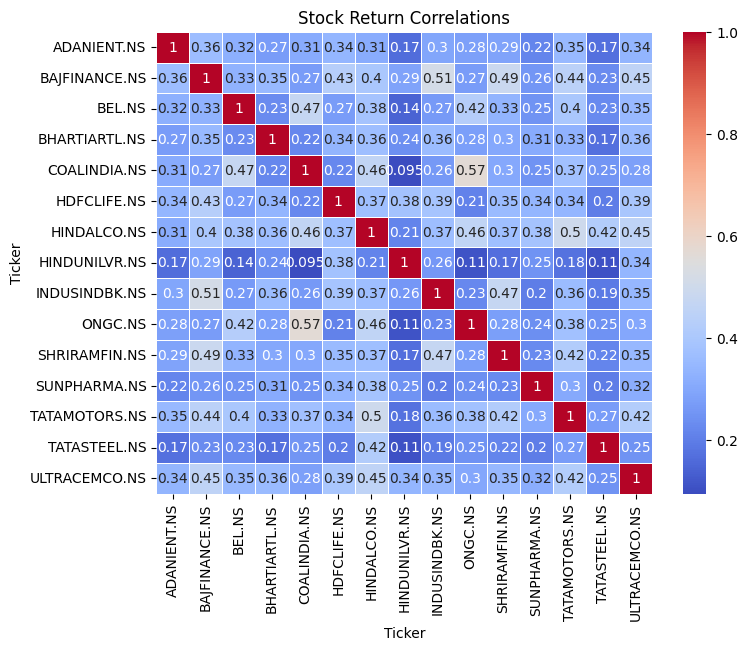

Ticker
TATASTEEL.NS    -1.763351
ADANIENT.NS     -1.901354
INDUSINDBK.NS   -2.146768
SHRIRAMFIN.NS   -2.181850
TATAMOTORS.NS   -2.460149
HINDALCO.NS     -2.542279
BEL.NS          -2.700408
ONGC.NS         -2.729487
BAJFINANCE.NS   -2.778453
COALINDIA.NS    -3.211302
HDFCLIFE.NS     -3.488799
BHARTIARTL.NS   -3.701616
ULTRACEMCO.NS   -3.815949
SUNPHARMA.NS    -4.104503
HINDUNILVR.NS   -4.440178
dtype: float64


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(returns.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Stock Return Correlations")
plt.show()

stock_sharpe = (returns.mean() - risk_free_rate) / returns.std()
print(stock_sharpe.sort_values(ascending=False))

In [5]:
#Market Equilibrium Returns
market_index = yf.download('^NSEI', start=start_date, end=end_date)['Close'].pct_change().dropna()
market_index.name = "^NSEI"
returns["^NSEI"] = market_index

market_eq_returns = returns.mean()

[*********************100%***********************]  1 of 1 completed


In [6]:
from sklearn.linear_model import LassoCV
from bs4 import BeautifulSoup
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV

# Prepare
X = returns.drop(columns=["^NSEI"])
y = returns["^NSEI"].dropna()
X, y = X.align(y, join="inner", axis=0)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train
elastic_net = ElasticNetCV(
    l1_ratio=np.linspace(0.1, 0.9, 9),
    alphas=np.logspace(-7, 0, 300),
    cv=50,
    max_iter=200000,
    n_jobs=-1
).fit(X_scaled, y)

# Extract
coefficients = pd.Series(elastic_net.coef_, index=X.columns)

# Display
print(f"Best Alpha: {elastic_net.alpha_}")
print(f"Best L1 Ratio: {elastic_net.l1_ratio_}")

Best Alpha: 0.0010635449574860113
Best L1 Ratio: 0.1


In [8]:
# Define Views
num_views = min(12, (coefficients != 0).sum())
positive_stocks = coefficients.nlargest(num_views // 2).index.tolist()
negative_stocks = coefficients.nsmallest(num_views // 2).index.tolist()

ticker_mapping = {}
for i, stock in enumerate(positive_stocks + negative_stocks):
    ticker_mapping[stock] = (i // 2, 1 if stock in positive_stocks else -1)

In [9]:
# Construct P Matrix
valid_tickers = returns.columns.tolist()
P = np.zeros((num_views, len(valid_tickers)))
for stock, (row, val) in ticker_mapping.items():
    if stock in valid_tickers:
        P[row, valid_tickers.index(stock)] = val

In [10]:
valid_keys = [stock for stock in ticker_mapping.keys() if stock in coefficients.index]
Q = coefficients.loc[valid_keys].values.reshape(-1, 1)
P = P[:len(valid_keys), :]  # Trim
assert P.shape[0] == Q.shape[0], f"P rows ({P.shape[0]}) and Q rows ({Q.shape[0]}) must match!"

In [11]:
# Display
print("P Matrix:")
print(P)
print("\nQ Vector:")
print(Q)

P Matrix:
[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]

Q Vector:
[[0.00256749]
 [0.00214626]
 [0.00144281]
 [0.00142086]
 [0.00135808]
 [0.00125112]
 [0.00022692]
 [0.00053666]
 [0.00064715]
 [0.00069476]
 [0.00074357]
 [0.00088824]]


In [12]:
print(returns.shape[1])
print(returns.columns)

16
Index(['ADANIENT.NS', 'BAJFINANCE.NS', 'BEL.NS', 'BHARTIARTL.NS',
       'COALINDIA.NS', 'HDFCLIFE.NS', 'HINDALCO.NS', 'HINDUNILVR.NS',
       'INDUSINDBK.NS', 'ONGC.NS', 'SHRIRAMFIN.NS', 'SUNPHARMA.NS',
       'TATAMOTORS.NS', 'TATASTEEL.NS', 'ULTRACEMCO.NS', '^NSEI'],
      dtype='object', name='Ticker')


In [13]:
# Compute Omega
confidence_factor = 0.5
omega = confidence_factor * np.diag(np.diag(P @ returns.cov().values @ P.T)) + np.eye(P.shape[0]) * 1e-2

In [14]:
tau = 0.015 + (returns.std().mean() / 10)  # Adjust tau on volatility
regularization_strength = 0.002
cov_matrix = returns.cov().values + np.eye(len(valid_tickers)) * regularization_strength
inv_tau_cov = np.linalg.pinv(tau * cov_matrix)
inv_omega = np.linalg.pinv(np.diag(np.full(P.shape[0], 0.05)))
M_inverse = np.linalg.pinv(inv_tau_cov + P.T @ inv_omega @ P)
market_mean = np.full((len(valid_tickers), 1), market_index.mean())
post_mean = M_inverse @ (inv_tau_cov @ market_mean + P.T @ inv_omega @ Q)

# Normalize
post_mean = np.clip(post_mean * 100, -10, 10)

In [15]:
posterior_mean = np.clip(post_mean, post_mean.mean() - 2 * post_mean.std(), post_mean.mean() + 2 * post_mean.std())

In [16]:
print("P shape:", P.shape)
print("Q shape:", Q.shape)
print("market_mean shape:", market_mean.shape)
print("inv_tau_cov shape:", inv_tau_cov.shape)
print("inv_omega shape:", inv_omega.shape)
print("M_inverse shape:", M_inverse.shape)

P shape: (12, 16)
Q shape: (12, 1)
market_mean shape: (16, 1)
inv_tau_cov shape: (16, 16)
inv_omega shape: (12, 12)
M_inverse shape: (16, 16)


In [17]:
cov_matrix = returns.cov().values
rank = np.linalg.matrix_rank(cov_matrix)
print(f"Rank of Covariance Matrix: {rank} / {cov_matrix.shape[0]}")

Rank of Covariance Matrix: 16 / 16


In [18]:
print("NaN values in returns:", returns.isna().sum().sum())
print("Constant columns:", (returns.std() == 0).sum())

NaN values in returns: 1
Constant columns: 0


In [19]:
returns = returns.dropna()

In [20]:
# Sector Classification
sector_mapping = {
    "TATASTEEL.NS": "Metals",
    "HINDALCO.NS": "Metals",
    "ONGC.NS": "Energy",
    "SHRIRAMFIN.NS": "Financials",
    "ADANIENT.NS": "Conglomerate",
    "BAJFINANCE.NS": "Financials",
    "INDUSINDBK.NS": "Financials",
    "BEL.NS": "Defense",
    "HINDUNILVR.NS": "FMCG",
    "ULTRACEMCO.NS": "Cement",
    "HDFCLIFE.NS": "Insurance",
    "BHARTIARTL.NS": "Telecom",
    "COALINDIA.NS": "Energy",
    "SUNPHARMA.NS": "Pharma"
}


#Sector Constraints
sector_limits = {
    "Metals": 0.30,
    "Financials": 0.40,
    "Energy": 0.25,
    "Conglomerate": 0.15,
    "Defense": 0.25,
    "FMCG": 0.20,
    "Pharma": 0.25,
    "Cement": 0.20,
    "Insurance": 0.15,
    "Telecom": 0.15
}


In [21]:
from scipy.optimize import LinearConstraint

def sector_constrained_optimization(returns, expected_returns, sector_mapping, sector_limits):
    num_assets = len(expected_returns)
    cov_matrix = np.cov(returns, rowvar=False) + np.eye(num_assets) * 1e-3

    # sector allocation
    sector_matrix = np.zeros((len(sector_limits), num_assets))
    sector_index = {sector: i for i, sector in enumerate(sector_limits.keys())}

    for i, asset in enumerate(returns.columns):
        if asset in sector_mapping:
            sector = sector_mapping[asset]
            if sector in sector_index:
                sector_matrix[sector_index[sector], i] = 1

    sector_bounds = list(sector_limits.values())

    def objective(weights):
       lambda_vol = 0.5
       lambda_drawdown = 0.3

       portfolio_return = weights @ expected_returns.flatten()
       portfolio_volatility = np.sqrt(weights @ cov_matrix @ weights.T)

       # Compute max drawdown
       cumulative_returns = np.cumprod(1 + returns @ weights) - 1
       drawdown = np.min(cumulative_returns)

       # Adjusted Sharpe ratio
       return -((portfolio_return - risk_free_rate) / portfolio_volatility - lambda_vol * portfolio_volatility - lambda_drawdown * abs(drawdown))


    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},
        {'type': 'ineq', 'fun': lambda w: 0.30 - np.max(w)},
    ]

    sector_constraint = LinearConstraint(sector_matrix, lb=0, ub=sector_bounds)

    bounds = [(0.01, 0.12)] * num_assets
    initial_weights = np.ones(num_assets) / num_assets

    result = minimize(objective, initial_weights, bounds=bounds, constraints=[*constraints, sector_constraint], method='SLSQP')

    return result.x if result.success else np.zeros(num_assets)

# Run
optimized_weights_sector = sector_constrained_optimization(returns, posterior_mean, sector_mapping, sector_limits)

print("\n Optimized Portfolio Weights with Sector Constraints:\n", optimized_weights_sector)

# Save
portfolio_allocation = pd.DataFrame({'Stock': returns.columns.tolist(), 'Weight': optimized_weights_sector})
print(portfolio_allocation.sort_values(by='Weight', ascending=False))


 Optimized Portfolio Weights with Sector Constraints:
 [0.12 0.12 0.12 0.01 0.01 0.01 0.12 0.01 0.01 0.01 0.12 0.01 0.12 0.12
 0.08 0.01]
            Stock  Weight
0     ADANIENT.NS    0.12
2          BEL.NS    0.12
10  SHRIRAMFIN.NS    0.12
12  TATAMOTORS.NS    0.12
13   TATASTEEL.NS    0.12
6     HINDALCO.NS    0.12
1   BAJFINANCE.NS    0.12
14  ULTRACEMCO.NS    0.08
3   BHARTIARTL.NS    0.01
9         ONGC.NS    0.01
11   SUNPHARMA.NS    0.01
4    COALINDIA.NS    0.01
5     HDFCLIFE.NS    0.01
7   HINDUNILVR.NS    0.01
8   INDUSINDBK.NS    0.01
15          ^NSEI    0.01


In [22]:
print("Posterior Mean Returns:\n", posterior_mean)

Posterior Mean Returns:
 [[0.06065417]
 [0.06104595]
 [0.06069921]
 [0.06096031]
 [0.06071787]
 [0.06102713]
 [0.06090746]
 [0.06105543]
 [0.06095698]
 [0.06069255]
 [0.06092379]
 [0.06077579]
 [0.06090654]
 [0.06063442]
 [0.06105208]
 [0.06095011]]


In [23]:
# Display Results
portfolio_allocation = pd.DataFrame({'Stock': returns.columns.tolist(), 'Weight': optimized_weights_sector})
print(portfolio_allocation.sort_values(by='Weight', ascending=False))

            Stock  Weight
0     ADANIENT.NS    0.12
2          BEL.NS    0.12
10  SHRIRAMFIN.NS    0.12
12  TATAMOTORS.NS    0.12
13   TATASTEEL.NS    0.12
6     HINDALCO.NS    0.12
1   BAJFINANCE.NS    0.12
14  ULTRACEMCO.NS    0.08
3   BHARTIARTL.NS    0.01
9         ONGC.NS    0.01
11   SUNPHARMA.NS    0.01
4    COALINDIA.NS    0.01
5     HDFCLIFE.NS    0.01
7   HINDUNILVR.NS    0.01
8   INDUSINDBK.NS    0.01
15          ^NSEI    0.01


In [24]:
market_mean = np.full((len(valid_tickers), 1), market_index.mean())
market_mean_annual = (1 + market_index.mean()) ** 252 - 1
market_mean = np.full((len(valid_tickers), 1), market_mean_annual)

In [25]:
print("Market Mean Daily:", market_index.mean())
print("Market Mean Annual:", market_mean_annual)
print("Posterior Mean Returns:\n", posterior_mean)

Market Mean Daily: Ticker
^NSEI    0.00061
dtype: float64
Market Mean Annual: Ticker
^NSEI    0.166107
dtype: float64
Posterior Mean Returns:
 [[0.06065417]
 [0.06104595]
 [0.06069921]
 [0.06096031]
 [0.06071787]
 [0.06102713]
 [0.06090746]
 [0.06105543]
 [0.06095698]
 [0.06069255]
 [0.06092379]
 [0.06077579]
 [0.06090654]
 [0.06063442]
 [0.06105208]
 [0.06095011]]


In [26]:
#########BACKTESTING AND STRESS TESTING

**BACKTESTING AND STRESS TESTING**

In [42]:
def sharpe_ratio(returns, risk_free_rate=0.07):
    excess_returns = returns.mean() - risk_free_rate / 252
    return excess_returns / returns.std()

def max_drawdown(cumulative_returns):
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

def portfolio_volatility(weights, cov_matrix):
    weights = np.array(weights)
    return np.sqrt(weights @ cov_matrix @ weights.T)

In [43]:
def backtest_portfolio(returns, weights, risk_free_rate=0.0675):
    portfolio_returns = returns @ weights
    cumulative_returns = (1 + portfolio_returns).cumprod()

    sharpe = sharpe_ratio(portfolio_returns, risk_free_rate)
    drawdown = max_drawdown(cumulative_returns)
    volatility = portfolio_volatility(weights, returns.cov())

    print("\nBacktest Results:")
    print(f"Sharpe Ratio: {sharpe:.4f}")
    print(f"Max Drawdown: {drawdown:.4%}")
    print(f"Portfolio Volatility: {volatility:.4%}")

    return sharpe, drawdown, volatility, portfolio_returns


In [44]:
def stress_test(returns, weights, shock_ticker=None, shock_percent=0.1):
    shocked_returns = returns.copy()
    if shock_ticker and shock_ticker in returns.columns:
        shocked_returns[shock_ticker] *= (1 - shock_percent)

    print(f"\n Stress Test: {shock_ticker} drops by {shock_percent*100}%")
    backtest_portfolio(shocked_returns, weights)

In [45]:
sharpe, drawdown, volatility, portfolio_returns = backtest_portfolio(returns, optimized_weights_sector)


Backtest Results:
Sharpe Ratio: 0.0725
Max Drawdown: -49.7536%
Portfolio Volatility: 1.7544%


**Bonus Challenge**

In [31]:
stress_test(returns, optimized_weights_sector, shock_ticker='BEL.NS', shock_percent=0.1)


 Stress Test: BEL.NS drops by 10.0%

Backtest Results:
Sharpe Ratio: 0.0718
Max Drawdown: -49.3888%
Portfolio Volatility: 1.7365%


In [33]:
import numpy as np

def monte_carlo_stress_test(returns, weights, num_simulations=10000, shock_range=(-0.1, 0.1)):
    shocked_returns = returns.copy()
    num_assets = returns.shape[1]
    simulated_results = []

    risk_free_rate = 0.0675 / 252

    for _ in range(num_simulations):
        shocks = np.random.uniform(shock_range[0], shock_range[1], num_assets)
        shocked_returns_simulated = shocked_returns * (1 + shocks)

        portfolio_returns = shocked_returns_simulated.dot(weights)

        sharpe = (portfolio_returns.mean() - risk_free_rate) / portfolio_returns.std()
        drawdown = max_drawdown((1 + portfolio_returns).clip(0.0001, None).cumprod())
        volatility = np.std(portfolio_returns)

        simulated_results.append([sharpe, drawdown, volatility])

    simulated_results = np.array(simulated_results)

    # Monte Carlo Results
    print("\n Monte Carlo Stress Test Summary:")
    print(f"Avg Sharpe Ratio: {simulated_results[:,0].mean():.4f}")
    print(f"Avg Max Drawdown: {simulated_results[:,1].mean():.4%}")
    print(f"Avg Portfolio Volatility: {simulated_results[:,2].mean():.4%}")

    return simulated_results

# Run Monte Carlo
monte_carlo_results = monte_carlo_stress_test(returns, optimized_weights_sector)


 Monte Carlo Stress Test Summary:
Avg Sharpe Ratio: 0.0725
Avg Max Drawdown: -49.7578%
Avg Portfolio Volatility: 1.7545%


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


               Q Change -20%  Q Change -10%  Q Change 10%  Q Change 20%
Ticker                                                                 
ADANIENT.NS         0.120000       0.120000      0.120000      0.120000
BAJFINANCE.NS       0.010000       0.010000      0.010000      0.010000
BEL.NS              0.120000       0.120000      0.120000      0.120000
BHARTIARTL.NS       0.120000       0.120000      0.120000      0.120000
COALINDIA.NS        0.067443       0.067403      0.067275      0.067237
HDFCLIFE.NS         0.010000       0.010000      0.010000      0.010000
HINDALCO.NS         0.018388       0.018408      0.018360      0.018387
HINDUNILVR.NS       0.010000       0.010000      0.010000      0.010000
INDUSINDBK.NS       0.010000       0.010000      0.010000      0.010000
ONGC.NS             0.030493       0.030450      0.030417      0.030372
SHRIRAMFIN.NS       0.074058       0.074081      0.074144      0.074167
SUNPHARMA.NS        0.120000       0.120000      0.120000      0

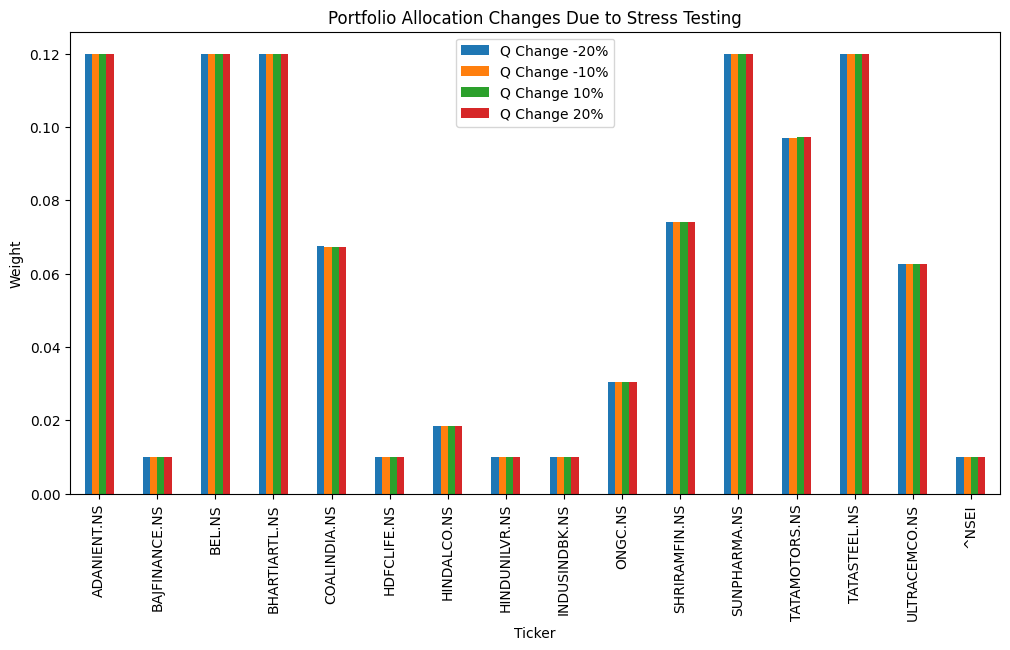

In [34]:
import copy
import numpy as np
import matplotlib.pyplot as plt

def sensitivity_analysis(returns, P, Q, omega, tau, cov_matrix, risk_free_rate, sector_mapping, sector_limits, changes=[-0.2, -0.1, 0.1, 0.2]):
    """
    Perform stress testing by adjusting subjective views (Q) and checking impact on portfolio allocation.

    Parameters:
    - returns: Stock returns
    - P: Pick matrix
    - Q: Subjective views on excess returns
    - omega: Confidence matrix
    - tau: Scaling factor
    - cov_matrix: Covariance matrix
    - risk_free_rate: Risk-free rate
    - sector_mapping: Dictionary of stock-to-sector mapping
    - sector_limits: Dictionary of sector allocation limits
    - changes: List of percentage changes to apply to Q (default: [-20%, -10%, +10%, +20%])

    Returns:
    - allocations: Dictionary with portfolio weights under different scenarios
    """
    original_Q = copy.deepcopy(Q)
    allocations = {}

    for change in changes:
        adjusted_Q = original_Q * (1 + change)

        # Compute adjusted Black-Litterman
        inv_tau_cov = np.linalg.pinv(tau * cov_matrix)
        inv_omega = np.linalg.pinv(omega)
        M_inverse = np.linalg.pinv(inv_tau_cov + P.T @ inv_omega @ P)
        posterior_mean = M_inverse @ (inv_tau_cov @ returns.mean().values.reshape(-1, 1) + P.T @ inv_omega @ adjusted_Q)

        # Normalize
        posterior_mean = np.clip(posterior_mean * 100, -5, 5)

        # Optimize portfolio with sector constraints
        optimized_weights = sector_constrained_optimization(returns, posterior_mean, sector_mapping, sector_limits)

        # Store
        allocations[f"Q Change {change*100:.0f}%"] = optimized_weights

    return allocations

# Run Analysis
sensitivity_results = sensitivity_analysis(returns, P, Q, omega, tau, cov_matrix, risk_free_rate, sector_mapping, sector_limits)

# Convert to DataFrame
sensitivity_df = pd.DataFrame(sensitivity_results, index=returns.columns)
print(sensitivity_df)

# Plot
sensitivity_df.plot(kind="bar", figsize=(12,6), title="Portfolio Allocation Changes Due to Stress Testing")
plt.ylabel("Weight")
plt.show()

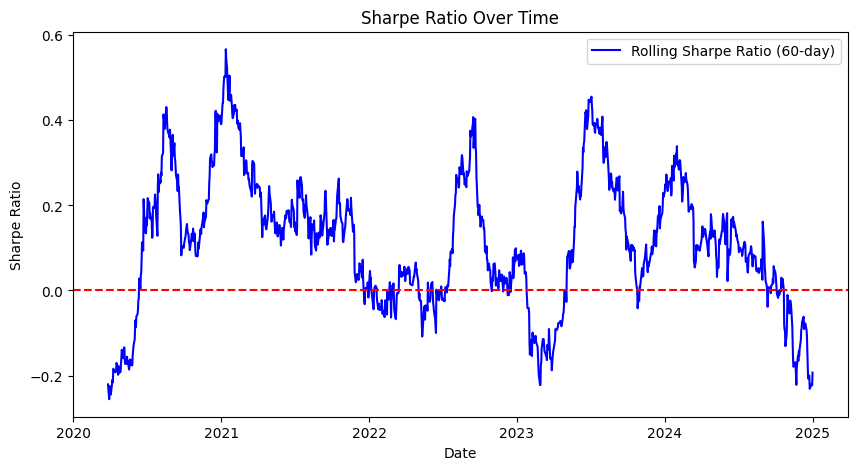

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def rolling_sharpe_ratio(returns, window=60, risk_free_rate=0.0675):
    excess_returns = returns - risk_free_rate / 252
    rolling_sharpe = excess_returns.rolling(window).mean() / excess_returns.rolling(window).std()
    return rolling_sharpe

rolling_sharpe = rolling_sharpe_ratio(portfolio_returns)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(rolling_sharpe, label="Rolling Sharpe Ratio (60-day)", color='blue')
plt.axhline(y=0, color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio Over Time")
plt.legend()
plt.show()


In [36]:
import yfinance as yf

nifty50_data = yf.download('^NSEI', start=start_date, end=end_date)['Close']

nifty50 = nifty50_data.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:200: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  offsets = np.asanyarray(offsets, float)
<ipython-input-37-57672363478b>:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (df_assets["Risk"][i], df_assets["Return"][i]), fontsize=12, xytext=(10,5), textcoords='offset points')
/usr/local/lib/python3.11/dist-packages/matplotlib/text.py:1475: FutureWarning: Calling float on a single element S

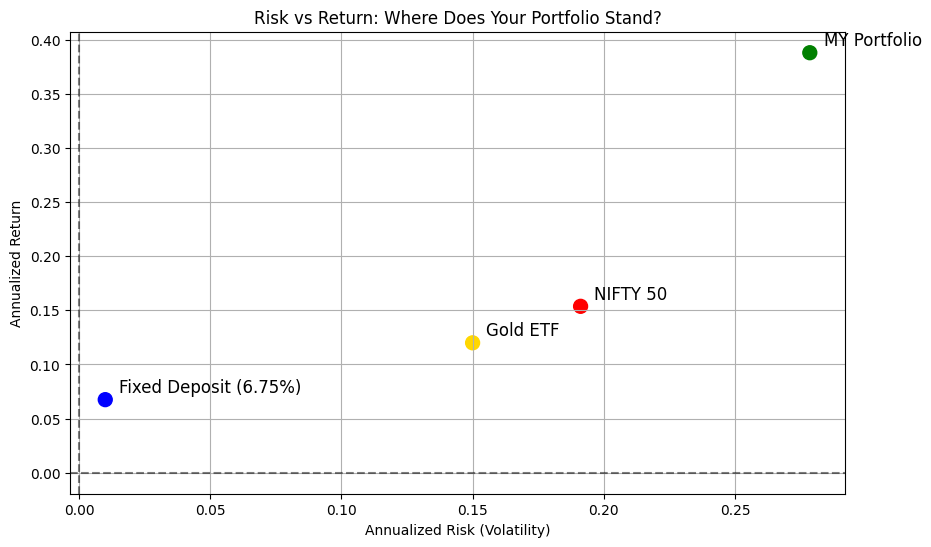

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_risk_return(returns):
    annual_return = returns.mean() * 252
    annual_volatility = returns.std() * np.sqrt(252)
    return annual_return, annual_volatility

# Portfolio metrics
portfolio_return, portfolio_risk = compute_risk_return(portfolio_returns)

# Benchmark
nifty50_return, nifty50_risk = compute_risk_return(nifty50)

sample_assets = {
    "NIFTY 50": (nifty50_return, nifty50_risk),
    "Fixed Deposit (6.75%)": (0.0675, 0.01),
    "Gold ETF": (0.12, 0.15),
}

# Convert
df_assets = pd.DataFrame(sample_assets, index=["Return", "Risk"]).T
df_assets.loc["MY Portfolio"] = [portfolio_return, portfolio_risk]

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_assets["Risk"], df_assets["Return"], color=['red', 'blue', 'gold', 'green'], s=100)

# Annotate points
for i, txt in enumerate(df_assets.index):
    plt.annotate(txt, (df_assets["Risk"][i], df_assets["Return"][i]), fontsize=12, xytext=(10,5), textcoords='offset points')

# Labels
plt.xlabel("Annualized Risk (Volatility)")
plt.ylabel("Annualized Return")
plt.title("Risk vs Return: Where Does Your Portfolio Stand?")
plt.axhline(y=0, color='black', linestyle='dashed', alpha=0.5)
plt.axvline(x=0, color='black', linestyle='dashed', alpha=0.5)
plt.grid(True)
plt.show()

In [38]:
nifty50_return, nifty50_risk = compute_risk_return(nifty50)

print(f"NIFTY 50 Annual Return: {nifty50_return.iloc[0] * 100:.2f}%")
print(f"NIFTY 50 Annual Risk (Volatility): {nifty50_risk.iloc[0] * 100:.2f}%")

NIFTY 50 Annual Return: 15.37%
NIFTY 50 Annual Risk (Volatility): 19.12%


In [39]:
alpha = portfolio_return - nifty50_return.iloc[0]
# Print Results
print(f"Portfolio Expected Annual Return: {portfolio_return * 100:.2f}%")
print(f"NIFTY 50 Benchmark Annual Return: {nifty50_return.iloc[0] * 100:.2f}%")
print(f"Alpha (Excess Return): {alpha * 100:.2f}%")

Portfolio Expected Annual Return: 38.80%
NIFTY 50 Benchmark Annual Return: 15.37%
Alpha (Excess Return): 23.43%
